# Notebook to see the best dataset statistics -> to use in report

In [1]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import numpy as np
import joblib
import spacy

## Loading Dataset

In [2]:
# loading the dataset

# paths
train_csv = "../data/train.csv"
val_csv   = "../data/val.csv"
test_csv  = "../data/test.csv"

# load; all of them have 2 columns: Text, Label
train = pd.read_csv(train_csv)
val   = pd.read_csv(val_csv)
test  = pd.read_csv(test_csv)

print("Train:", train.shape, "Val:", val.shape, "Test:", test.shape)

# load Portuguese model
nlp = spacy.load("pt_core_news_lg")

# lemmatize a text using SpaCy
def lemmatize_text(text):
    doc = nlp(text)
    # join lemmas back into a string
    return " ".join([token.lemma_ for token in doc if not token.is_punct])

# cleaning the dataset - lowercases and removes extra whitespaces in every text
def clean_data(text):
    #check for actual missing values
    if pd.isna(text) or text is None:
        return None
        
    #convert to string and strip whitespace
    text_str = str(text).lower().strip()
    
    #check for literal string "None", "nan", or empty
    if text_str in ['none', 'nan', 'null', '']:
        return None
    
    return text_str

# first clean
train['text_clean'] = train['Text'].apply(clean_data)
val['text_clean']   = val['Text'].apply(clean_data)
test['text_clean']  = test['Text'].apply(clean_data)

# drop nulls
train = train.dropna(subset=['text_clean']).reset_index(drop=True)
val   = val.dropna(subset=['text_clean']).reset_index(drop=True)
test  = test.dropna(subset=['text_clean']).reset_index(drop=True)

# then lemmatize
train['text_clean'] = train['text_clean'].apply(lemmatize_text)
val['text_clean']   = val['text_clean'].apply(lemmatize_text)
test['text_clean']  = test['text_clean'].apply(lemmatize_text)

# fit on training texts and transform all splits
tfidf = joblib.load("../artifacts/lemmatization/tfidf_vectorizer.joblib")

X_train = tfidf.transform(train['text_clean'])
X_val   = tfidf.transform(val['text_clean'])
X_test  = tfidf.transform(test['text_clean'])
y_test  = test['Label'].astype(int).values

print("TF-IDF shapes:", X_train.shape, X_val.shape, X_test.shape)

Train: (50587, 2) Val: (6324, 2) Test: (6324, 2)
TF-IDF shapes: (50554, 5000) (6321, 5000) (6320, 5000)


## Word Cloud

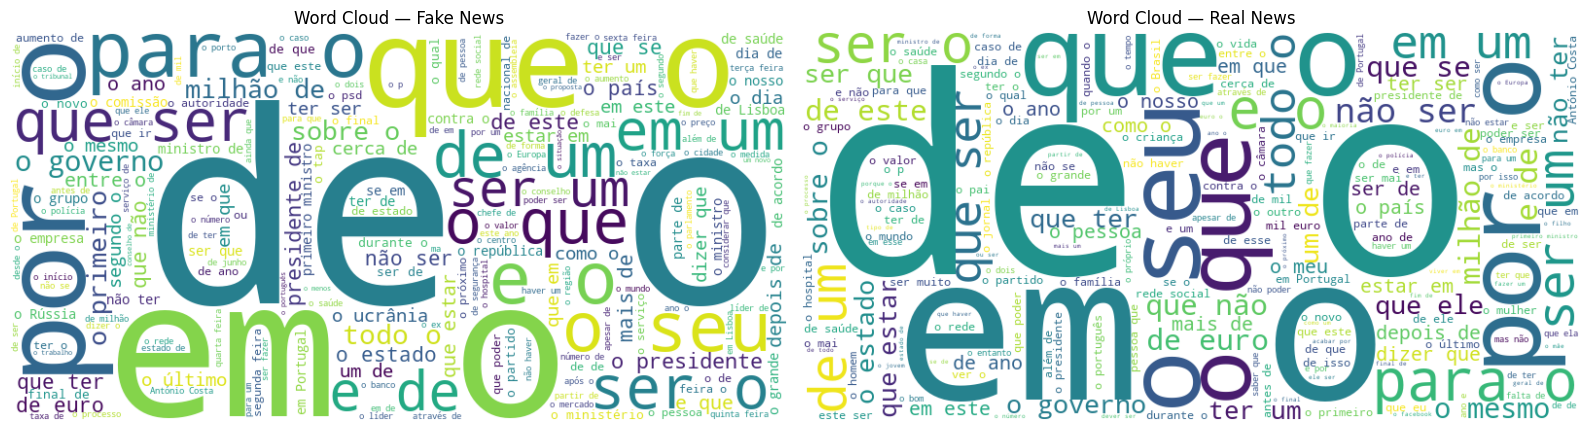

In [4]:
# Separate Fake vs Real
fake_texts = train.loc[train['Label'] == 1, 'text_clean']
real_texts = train.loc[train['Label'] == 0, 'text_clean']

# Combine all texts per class
fake_combined = " ".join(fake_texts)
real_combined = " ".join(real_texts)

# Generate Word Clouds
wordcloud_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_combined)
wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(real_combined)

# Plot
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title("Word Cloud — Fake News")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.title("Word Cloud — Real News")
plt.axis("off")

plt.tight_layout()
plt.savefig("../../assets/visualizations/wordcloud_fake_real.png")
plt.show()


## TF-IDF Heatmap

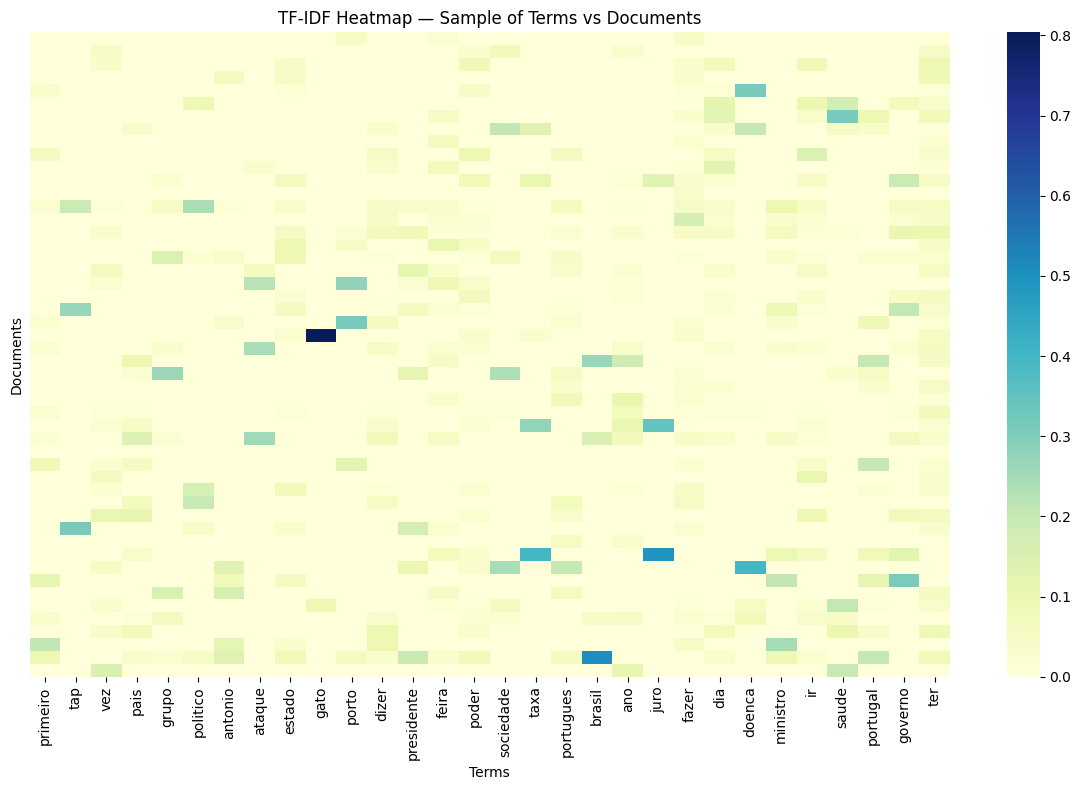

In [5]:
# Take a small sample for visualization
num_samples = 50
X_sample = X_train[:num_samples].toarray()  # dense for heatmap
terms = np.array(tfidf.get_feature_names_out())

# Pick top 30 terms by average TF-IDF for better visualization
top_term_indices = np.argsort(X_sample.mean(axis=0))[-30:]
X_sample_top = X_sample[:, top_term_indices]
terms_top = terms[top_term_indices]

plt.figure(figsize=(12, 8))
sns.heatmap(X_sample_top, cmap="YlGnBu", yticklabels=False, xticklabels=terms_top)
plt.title("TF-IDF Heatmap — Sample of Terms vs Documents")
plt.xlabel("Terms")
plt.ylabel("Documents")
plt.tight_layout()
plt.savefig("../../assets/visualizations/tfidf_heatmap.png")
plt.show()
